## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)
# one-hot encoding
df = pd.get_dummies(df)

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]
# turn to numpy array
x_train = np.delete(train_df.to_numpy(), 12, axis=1)
y_train = train_df.to_numpy()[:,12]
x_test = np.delete(test_df.to_numpy(), 12, axis=1)
y_test = test_df.to_numpy()[:,12]
# number of attributes
num_attribute = x_train[0].size

In [76]:
train_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
136,54,1,2,192,283,0,2,195,0,0.0,1,1,0,0,0,0,0,1
232,58,0,4,170,225,1,2,146,1,2.8,2,2,1,0,0,1,0,0
233,56,1,2,130,221,0,2,163,0,0.0,1,0,0,0,0,0,0,1
184,46,1,4,120,249,0,2,144,0,0.8,1,0,0,0,0,0,0,1
84,55,0,2,135,250,0,2,161,0,1.4,2,0,0,0,0,0,1,0


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [3]:
def gini(sequence):
  arr = np.bincount(sequence)
  pure = arr/sequence.size
  init = 1
  for x in pure:
    init -= np.square(x)
  return init

def entropy(sequence):
  arr = np.bincount(sequence)
  pure = arr/sequence.size
  init = 0
  for x in pure:
    if(x!=0):
      init += x*np.log2(x)
  return -init

In [40]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [45]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [80]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [4]:
# used in question 3
feature_used = np.zeros(13)
dictionary = dict()
for i, x in enumerate(df):
  if i<=11:
    dictionary[x] = i
  else:
    dictionary['thal'] = 12

In [5]:
class Node():
  def __init__(self, partition_att=None, partition_val=None, data=None, left=None, right=None):
    self.partition_att = partition_att
    self.partition_val = partition_val
    self.data = data
    self.left = left
    self.right = right

In [6]:
class DecisionTree():
  def __init__(self,
        criterion='gini', max_depth=None,
        x_train=None, y_train=None,
        x_test=None, y_test=None):
    # numpy arrays
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    # index stored in the node
    self.train_idx = np.arange(x_train.size/x_train[0].size, dtype=int)
    self.test_idx = np.arange(x_test.size/x_test[0].size, dtype=int)
    self.node = self.build_tree(criterion, max_depth, self.train_idx)
    self.test_res = []
    self.wrong_results = []
    for test_data in self.test_idx:
      self.test_res.append(self.test_tree(criterion, self.node, test_data))
    self.test_res = np.array(self.test_res)
    for i, res in enumerate(self.test_res):
      if self.test_res[i]!=self.y_test[i]:
        self.wrong_results.append(i)
    self.wrong_results = np.array(self.wrong_results, dtype=int)
    self.accuracy = accuracy_score(self.test_res, self.y_test)

  def build_tree(self, criterion='gini', depth=None, data=None):
    newNode = Node()
    if np.all(self.y_train[data]==self.y_train[data][0]):
      newNode.data = self.y_train[data][0]
      return newNode
    if depth==0:
      zeros = (np.array(self.y_train[data], dtype=int)==0).sum()
      ones = (np.array(self.y_train[data], dtype=int)==1).sum()
      newNode.data = 0 if zeros>ones else 1
      return newNode
      
    newNode.data = data
    min_criterion = 1

    # use i to represent each attribute
    for i in range(num_attribute):
      # every value of this attribute inside this node 
      tmp = np.unique(self.x_train[data][:,i])
      # use j to partition the attribute
      for j in tmp:
        # only target value
        left = []
        right = []
        # partition data into two arrays
        left_data = []
        right_data = []
        # use x to represent each value in the current node
        for x in data:
          if self.x_train[x][i]<j:
            left.append(int(self.y_train[x]))
            left_data.append(int(x))
          else:
            right.append(int(self.y_train[x]))
            right_data.append(int(x))
        left = np.array(left, dtype=int)
        right = np.array(right, dtype=int)
        left_data = np.array(left_data, dtype=int)
        right_data = np.array(right_data, dtype=int)
        # use gini as criterion
        if criterion=='gini':
          cur_gini = gini(left)*left.size/data.size + gini(right)*right.size/data.size
          if cur_gini<min_criterion:
            min_criterion = cur_gini
            newNode.partition_att = i
            newNode.partition_val = j
            newNode.left_data = left_data
            newNode.right_data = right_data
        # use entropy as criterion
        else:
          cur_entropy = entropy(left)*left.size/data.size + entropy(right)*right.size/data.size
          if cur_entropy<min_criterion:
            min_criterion = cur_entropy
            newNode.partition_att = i
            newNode.partition_val = j
            newNode.left_data = left_data
            newNode.right_data = right_data
    if newNode.partition_att<=11:
      feature_used[newNode.partition_att]+=1
    else:
      feature_used[12]+=1
    newNode.left = self.build_tree(criterion, depth-1 if depth!=None else None, newNode.left_data)
    newNode.right = self.build_tree(criterion, depth-1 if depth!=None else None, newNode.right_data)
    zeros = (np.array(self.y_train[data], dtype=int)==0).sum()
    ones = (np.array(self.y_train[data], dtype=int)==1).sum()
    newNode.data = 0 if zeros>ones else 1
    return newNode

  def test_tree(self, criterion='gini', node=None, data=None):
    if node.left==None:
      return node.data
    if self.x_test[data][node.partition_att]<node.partition_val:
      return self.test_tree(criterion, node.left, data)
    else:
      return self.test_tree(criterion, node.right, data)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [16]:
clf_depth3 = DecisionTree('gini', 3, 
              x_train, y_train
              ,x_test, y_test)
clf_depth10 = DecisionTree('gini', 10, 
              x_train, y_train
              ,x_test, y_test)
print(clf_depth3.accuracy, clf_depth10.accuracy)

0.78 0.69


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


In [191]:
clf_gini = DecisionTree('gini', 3,
            x_train, y_train,
            x_test, y_test)
clf_entropy = DecisionTree('entropy', 3,
            x_train, y_train,
            x_test, y_test)
print(clf_gini.accuracy, clf_entropy.accuracy)

0.78 0.76


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

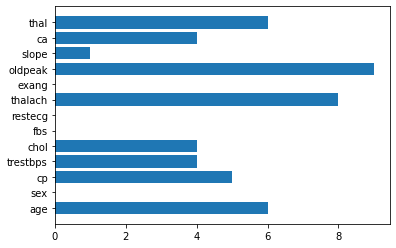

In [57]:
plt.barh(range(len(feature_used)), 
         feature_used,
         tick_label=list(dictionary.keys()))
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [192]:
class AdaBoost():
  def __init__(self, n_estimators):
    model1 = DecisionTree('gini', 1,
            x_train, y_train,
            x_train, y_train)
    model2 = DecisionTree('entropy', 2,
            x_train, y_train,
            x_train, y_train)
    x_train_num = int(x_train.size/x_train[0].size)
    self.weights = np.full(x_train_num, 1/x_train_num)
    self.alphas = []
    self.classifiers = []
    train_true = np.copy(y_train)
    for i, x in enumerate(train_true):
      if x==0:
        train_true[i] = -1
    self.test_res = []
    for iter in range(n_estimators):     
      fir_err = np.sum(self.weights[model1.wrong_results])
      sec_err = np.sum(self.weights[model2.wrong_results])   
      min_err = min(fir_err, sec_err)
      # result of classifier this round
      cur_res = np.array([])
      if min_err==fir_err:
        self.classifiers.append(1)
        cur_res = model1.test_res
      elif min_err==sec_err:
        self.classifiers.append(2)
        cur_res = model2.test_res
      self.alphas.append(1/2*np.log((1-min_err)/min_err))
      self.weights = self.weights*np.exp(-self.alphas[iter]*train_true*cur_res)
      self.weights /= np.sum(self.weights)
    self.classifiers = np.array(self.classifiers, dtype=int)
    for i, test_data in enumerate(y_test):
      # to record the data should be classified to which class
      classifier_res = []
      for round in range(n_estimators):
        cur_classifier = (DecisionTree('gini', 1, x_train, y_train, np.array([x_test[i]]), np.array([y_test[i]])) 
                  if self.classifiers[round]==1 else
                  DecisionTree('entropy', 2, x_train, y_train, np.array([x_test[i]]), np.array([y_test[i]]))) 
        classifier_res.append(-1 if cur_classifier.test_res[0]==0 else 1)
      
      self.test_res.append(1) if np.sum(np.dot(self.alphas, classifier_res)) >= 0 else self.test_res.append(0)
    self.accuracy = accuracy_score(self.test_res, y_test) 

In [193]:
es_ten = AdaBoost(10)
es_hun = AdaBoost(100)

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [275]:
print(es_ten.accuracy, es_hun.accuracy)

0.78 0.78


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [17]:
class RandomForest():
  def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini',
          max_depth=None ,x_train=None, y_train=None, x_test=None, y_test=None):
    self.n_estimators = n_estimators
    self.max_features = max_features
    self.boostrap = boostrap
    self.trees = []
    # numpy arrays
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    # index stored in the node
    self.train_idx = np.arange(x_train.size/x_train[0].size, dtype=int)
    self.test_idx = np.arange(x_test.size/x_test[0].size, dtype=int)
    for i in range(n_estimators):
      newNode = self.build_tree(criterion, max_depth, self.train_idx)
      self.trees.append(newNode)
    self.test_res = []
    
    for test_data in self.test_idx:
      zero = 0
      one = 0
      for tree in self.trees:
        if self.test_tree(criterion, tree, test_data)==1:
          one += 1
        else:
          zero += 1
      self.test_res.append(1 if one>zero else 0)
    self.test_res = np.array(self.test_res)
    self.accuracy = accuracy_score(self.test_res, self.y_test)

  def build_tree(self, criterion='gini', depth=None, data=None):
    newNode = Node()
    if data.size==0:
      newNode.data = 0
      return newNode
    if np.all(self.y_train[data]==self.y_train[data][0]):
      newNode.data = self.y_train[data][0]
      return newNode
    if depth==0:
      tmp = np.bincount(np.array(self.y_train[data], dtype=int))
      newNode.data = 0 if tmp[0]>tmp[1] else 1
      return newNode
      
    newNode.data = data
    min_criterion = 1
    # listing attribute to use
    arr = np.array([])

    # use i to represent each attribute
    if self.boostrap:
      arr = np.random.choice(range(num_attribute), int(self.max_features))
    else:
      arr = np.random.sample(range(num_attribute), int(self.max_features))
    for i in arr:
      # every value of this attribute inside this node 
      tmp = np.unique(self.x_train[data][:,i])
      # use j to partition the attribute
      for j in tmp:
        # only target value
        left = []
        right = []
        # partition data into two arrays
        left_data = []
        right_data = []
        # use x to represent each value in the current node
        for x in data:
          if self.x_train[x][i]<j:
            left.append(int(self.y_train[x]))
            left_data.append(int(x))
          else:
            right.append(int(self.y_train[x]))
            right_data.append(int(x))
        left = np.array(left, dtype=int)
        right = np.array(right, dtype=int)
        left_data = np.array(left_data, dtype=int)
        right_data = np.array(right_data, dtype=int)
        # use gini as criterion
        if criterion=='gini':
          cur_gini = gini(left)*left.size/data.size + gini(right)*right.size/data.size
          if cur_gini<min_criterion:
            min_criterion = cur_gini
            newNode.partition_att = i
            newNode.partition_val = j
            newNode.left_data = left_data
            newNode.right_data = right_data
        # use entropy as criterion
        else:
          cur_entropy = entropy(left)*left.size/data.size + entropy(right)*right.size/data.size
          if cur_entropy<min_criterion:
            min_criterion = cur_entropy
            newNode.partition_att = i
            newNode.partition_val = j
            newNode.left_data = left_data
            newNode.right_data = right_data
    if newNode.partition_att<=11:
      feature_used[newNode.partition_att]+=1
    else:
      feature_used[12]+=1
    newNode.left = self.build_tree(criterion, depth-1 if depth!=None else None, newNode.left_data)
    newNode.right = self.build_tree(criterion, depth-1 if depth!=None else None, newNode.right_data)
    tmp = np.bincount(np.array(self.y_train[data], dtype=int))
    newNode.data = 0 if tmp[0]>tmp[1] else 1
    return newNode

  def test_tree(self, criterion='gini', node=None, data=None):
    if node.left==None:
      return node.data
    if self.x_test[data][node.partition_att]<node.partition_val:
      return self.test_tree(criterion, node.left, data)
    else:
      return self.test_tree(criterion, node.right, data)
    

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [22]:
clf_10tree = RandomForest(10, np.sqrt(x_train.shape[1]), True, 'gini',
          None ,x_train, y_train, x_test, y_test)
clf_100tree = RandomForest(100, np.sqrt(x_train.shape[1]), True, 'gini',
          None ,x_train, y_train, x_test, y_test)

In [23]:
print(clf_10tree.accuracy, clf_100tree.accuracy)

0.8 0.74


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [26]:
clf_random_features = RandomForest(10, np.sqrt(x_train.shape[1]), True, 'gini',
          None ,x_train, y_train, x_test, y_test)
clf_all_features = RandomForest(10, x_train.shape[1], True, 'gini',
          None ,x_train, y_train, x_test, y_test)

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [27]:
print(clf_random_features.accuracy, clf_all_features.accuracy)

0.82 0.77


### Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [ ]:
from sklearn.metrics import accuracy_score

In [317]:
best_result = RandomForest(20, np.sqrt(x_train.shape[1]), True, 'entropy',
          3 ,x_train, y_train, x_test, y_test)
print(best_result.accuracy)

0.86


## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 